In [19]:
# -*- coding: utf-8 -*-
from matplotlib.pyplot import imshow
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
from torchvision import models
import torch.multiprocessing as mp
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import time
import importlib
import os
import argparse
import copy
import datetime
import random
import sys
import json

### My libs
from core.utils import Stack, ToTorchFormatTensor
from core.utils import ZipReader
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:

ref_length = 10
neighbor_stride = 5
default_fps = 15



In [21]:
torch.cuda.set_device(1)
device = 'cuda'
    
MASK_TYPE = 'object'
CKPT = 'checkpoints/sttn.pth'
DATA_NAME = 'davis'
MODEL_NAME = 'vis'
w, h = 432, 240

_to_tensors = transforms.Compose([
  Stack(),
  ToTorchFormatTensor()])


def get_ref_index(neighbor_ids, length, split):
  ref_index = []
  for i in range(0, length, ref_length):
    if not i in neighbor_ids:
      ref_index.append(i)
  return ref_index


def get_mask(vname, f):
  if MASK_TYPE == 'fixed':
    m = np.zeros((h, w), np.uint8)
    m[h//2-h//8:h//2+h//8, w//2-w//8:w//2+w//8] = 255
    return Image.fromarray(m)
  elif MASK_TYPE == 'object':
    mname = f"{str(f).zfill(5)}.png"
    m = ZipReader.imread('datasets/{}/Annotations/{}.zip'.format(DATA_NAME, vname), mname).convert('L')
    m = np.array(m)
    m = np.array(m>0).astype(np.uint8)
    m = cv2.resize(m, (w,h), cv2.INTER_NEAREST)
    m = cv2.dilate(m, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)), iterations=4)
    return Image.fromarray(m*255)
  elif MASK_TYPE == 'random_obj':
    m = ZipReader.imread('datasets/random_masks/{}.zip'.format(DATA_NAME),\
      '{}.png'.format(vname)).resize((w, h))
    m = np.array(m)
    m = np.array(m>0).astype(np.uint8)
    return Image.fromarray(m*255)
  else:
    raise NotImplementedError(f"Mask type {MASK_TYPE} not exists")



In [22]:

# save ann to img by pyplt
def save_by_pyplt(I, anns, fname, cmap):
    dpi=100
    shape=np.shape(I)[0:2][::-1]
    size = [float(i)/dpi for i in shape]
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig,[0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(I)
    if anns is not None:
      ax.imshow(anns, alpha=0.7, cmap=cmap)
#     fig.savefig(fname, dpi=dpi)

In [23]:
# Model and version
net = importlib.import_module('model.' + MODEL_NAME)
model = net.InpaintGenerator().to(device)
data = torch.load(CKPT, map_location = device) 
model.load_state_dict(data['netG'])
print('loading from: {}'.format(CKPT))
model.eval()

# prepare dataset
save_path = "./"
with open('datasets/{}/test.json'.format(DATA_NAME), 'r') as f:
    video_dict = json.load(f)
    video_names = list(videos_dict.keys())
video_names.sort()


loading from: checkpoints/sttn.pth


In [41]:
vi = np.random.randint(0, len(video_names))
vname = video_names[vi]
print(vi)

frame_names = [f"{str(i).zfill(5)}.jpg" for i in range(video_dict[vname])]
num_frames = video_dict[vname]
print('{} of {} frames ...'.format(vname, num_frames))
masks = []
frames = []
orig_frames = []
# preprocess data
for f, fname in enumerate(frame_names):
  img = ZipReader.imread('datasets/{}/JPEGImages/{}.zip'.format(DATA_NAME, vname), fname).convert('RGB')
  orig_frames.append(img)
  frames.append(img.resize((w, h)))
  m = get_mask(vname, f)
  masks.append(m)
binary_masks = [np.expand_dims((np.array(i)!=0).astype(np.uint8), 2) for i in masks]
comp_frames = [None]*len(frame_names)
pred_frames = [None]*len(frame_names)

feats = _to_tensors(frames).unsqueeze(0)*2-1
frames = [np.array(i).astype(np.uint8) for i in frames]
masks =  _to_tensors(masks).unsqueeze(0)
feats, masks = feats.to(device), masks.to(device)


81
surf of 55 frames ...


In [42]:

with torch.no_grad():
  feats = model.encoder((feats*(1-masks).float()).view(num_frames, 3, h, w))
  _, c, feat_h, feat_w = feats.size()
  feats = feats.view(1, num_frames, c, feat_h, feat_w)


show...


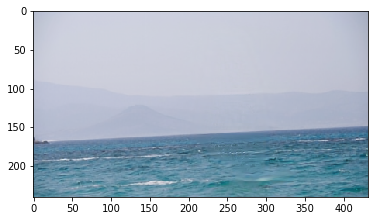

In [43]:
# begin inference 
for f in range(len(frame_names)//2, len(frame_names), neighbor_stride):
  neighbor_ids = [i for i in range(max(0,f-neighbor_stride), min(len(frame_names), f+neighbor_stride+1))]
  ref_ids = get_ref_index(neighbor_ids, len(frame_names), ref_length)
  with torch.no_grad():
    current_feat, attn, mm = model.infer(feats[0,neighbor_ids+ref_ids, :,:,:], masks[0,neighbor_ids+ref_ids,:,:,:])
    current_img = torch.tanh(model.decoder(current_feat[:len(neighbor_ids),:,:,:])).detach()
#     current_img = torch.tanh(model.decoder(current_feat)).detach()
    pred_img = (current_img+1)/2
    pred_img = pred_img.cpu().permute(0,2,3,1).numpy()*255
    # visualize attention 
    vis_img = np.array(pred_img[0]).astype(np.uint8)
    imshow(vis_img)
    
  print('show...')
  break
  input('Enter something...')

  

neighbor_ids:  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32] 11
ref ids:  [0, 10, 20, 40, 50] 5
ids:  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 10, 20, 40, 50] 16
selected attention patch size:  16
16 25 20
target frame as 27


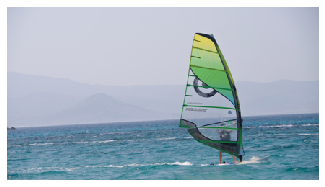

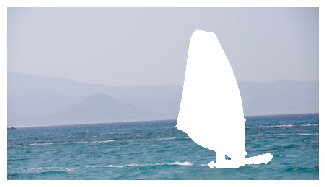

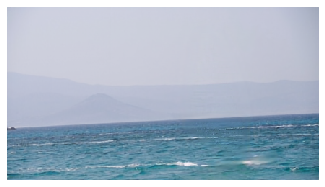

In [44]:
print('neighbor_ids: ', neighbor_ids, len(neighbor_ids))
print('ref ids: ', ref_ids, len(ref_ids))
ids = neighbor_ids+ref_ids
print('ids: ', ids, len(ids))

img = np.array(pred_img[len(neighbor_ids)//2+1]).astype(np.uint8)
input = frames[f]*(1-binary_masks[f])+255*binary_masks[f]
w, h = 432, 240
a = mm[len(neighbor_ids)//2+1].cpu().numpy().astype(np.float32)
print('selected attention patch size: ', mm.size()[0])

# select a target patch 
start = np.argmax(a)
end  = a.size - np.argmax(a[::-1]) - 1
a = cv2.resize(a, (w, h))
selected_patch=(start+end)//2

print(start, end, selected_patch)
print('target frame as {}'.format(f))
save_by_pyplt(frames[f], None, 'groundtruth_{}.jpg'.format(str(f).zfill(3)), 'Reds')
save_by_pyplt(input, None, 'input_{}.jpg'.format(str(f).zfill(3)), 'Reds')
save_by_pyplt(img, None, 'output_{}.jpg'.format(str(f).zfill(3)), 'Reds')
plt.show()

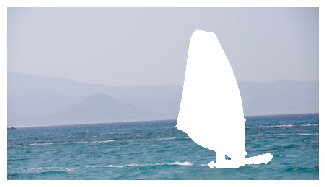

[ 1  2  5  4  6  0  3  7 13  8 14 12  9 10 11 15]
Attention from frame: 23


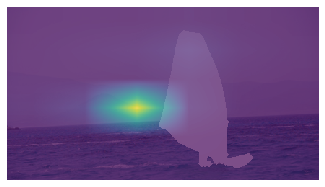

Attention from frame: 24


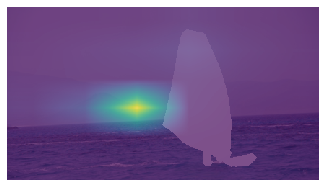

Attention from frame: 27


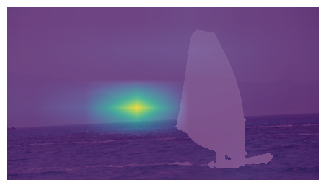

Attention from frame: 26


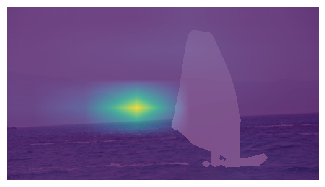

Attention from frame: 28


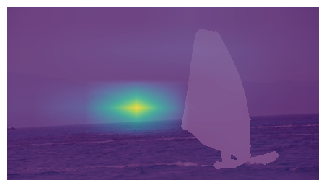

In [45]:

save_by_pyplt(input, None, 'target.jpg', 'Reds')
plt.show()

# find all attention value for selected patch 
np_attn = attn.cpu().numpy()
val = np_attn[selected_patch]

# sort attention 
ind = np.unravel_index(np.argsort(val, axis=None), val.shape)
ind_t, ind_x, ind_y = list(ind[0]), list(ind[1]), list(ind[2])
ind_t.reverse()
seen = set()
ind_t = np.array([x for x in ind_t if x not in seen and not seen.add(x)])
print(ind_t)

# show top 5 attended frames
for t in ind_t[:5]:
  print('Attention from frame: {}'.format(ids[t]))
  ref = frames[ids[t]]*(1-binary_masks[ids[t]])+255*binary_masks[ids[t]]
  a = cv2.resize(val[t], (w, h))
  save_by_pyplt(ref, a, 'ref_{}.jpg'.format(str(ids[t]).zfill(3)), None)
  plt.show()